# Initialization

In [1]:
import os
import grasp
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import fits
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc6121')


GAIA - GLOBULAR CLUSTERS ANALYSIS SOFTWARE
            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
         ::::::::::;;;::...

             INITIALIZED


Initialized with Gaia table: 'gaiadr3.gaia_source'


# Obtaining the sample

In [2]:
data = 'source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra,pmra_error, '\
    +'pmdec, pmdec_error, radial_velocity, radial_velocity_error, bp_rp, phot_g_mean_mag, '\
    +'phot_bp_mean_mag, phot_rp_mean_mag, teff_gspphot, pmra_pmdec_corr, ra_dec_corr'
conditions = []
conditions.append('parallax IS NOT NULL')
conditions.append('parallax BETWEEN 0.531632110579497 AND 0.5491488193300')
conditions.append('abs(parallax_error/parallax)<0.5')
conditions.append('abs(pmra_error/pmra)<0.3')
conditions.append('abs(pmdec_error/pmdec)<0.3')
conditions.append('pmra IS NOT NULL')
conditions.append('pmdec IS NOT NULL')
conditions.append('abs(pmra) > 0')
conditions.append('abs(pmdec) > 0')
conditions.append('pmra BETWEEN -13.742720 AND -11.295338')
conditions.append('pmdec BETWEEN -20.214805 AND -17.807517')
conditions2 = []
conditions2.append(conditions[-1])
conditions2.append(conditions[-2])
conditions2.append(conditions[0])
conditions2.append(conditions[1])
conditions2.append('ruwe < 1.15')
conditions2.append('phot_g_mean_mag > 11')
conditions2.append('astrometric_excess_noise_sig < 2')

pcs = dr3.free_gc_query(0.86, gc=gc, save=True, params=data, conds=conditions2)
acs = dr3.free_gc_query(0.86, gc=gc, save=True, params=data, conds=conditions)

Found data with the same conditions for object NGC6121 in
20250401_164228.
Loading it...
Sample number of sources: 913
Found data with the same conditions for object NGC6121 in
20250401_164231.
Loading it...
Sample number of sources: 920


<QTable length=1014>
         name          dtype     class     n_bad
--------------------- ------- ------------ -----
            SOURCE_ID   int64       Column     0
                   ra float64       Column     0
             ra_error float64       Column     0
                  dec float64       Column     0
            dec_error float64       Column     0
             parallax float64       Column     0
       parallax_error float64       Column     0
                 pmra float64       Column     0
           pmra_error float64       Column     0
                pmdec float64       Column     0
          pmdec_error float64       Column     0
      radial_velocity float64 MaskedColumn   923
radial_velocity_error float64 MaskedColumn   923
                bp_rp float64 MaskedColumn    31
      phot_g_mean_mag float64 MaskedColumn     1
     phot_bp_mean_mag float64 MaskedColumn    31
     phot_rp_mean_mag float64 MaskedColumn    30
         teff_gspphot float64 MaskedColumn   286

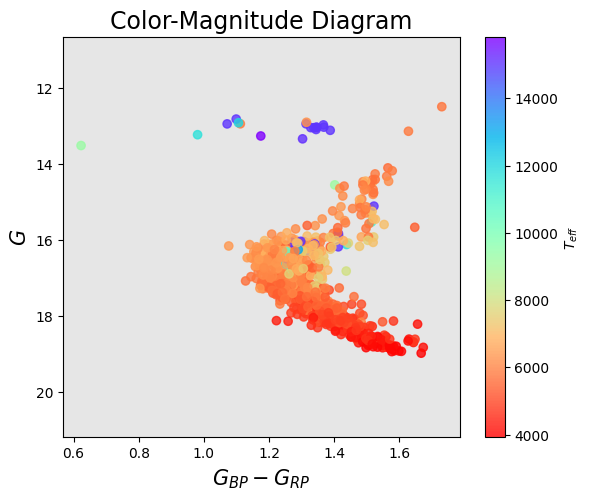

In [3]:
aps = acs.join(pcs)
aps.info()
grasp.plots.colorMagnitude(aps)

In [4]:
aps._merge_info

,SOURCE_ID,_merge
0,6045225224274703488,both
1,6045285869214078464,both
2,6045359678233524224,both
3,6045384206788014080,right_only
4,6045385791639303296,both
...,...,...
1009,6048487990668465664,both
1010,6048492461735982208,both
1011,6048511325232759040,both
1012,6048511909348318080,both


In [5]:
f = grasp.load_base_formulary()
f.display_all()


Angular Separation
theta_{2*D} = 2*asin(sqrt((sin((alpha_{0} - alpha_{1})/2)**2*cos(delta_{1}))*cos(delta_{0}) + sin((delta_{0} - delta_{1})/2)**2))

Los Distance
r_{x} = 1/omega

Radial Distance 2D
r_{2*d} = r_{c*g}*tan(theta_{2*D})

Gc Z Coordinate
d = -r_{c*g} + r_{x}

Radial Distance 3D
R = sqrt(d**2 + r_{2*d}**2)

In-Shell Dimentionless Poteff
Sigma = (-x + log(B, E)) - log(Delta_{N}/(sqrt(x)), E)

B Constant
B = 16*(A*(sqrt(2)*(pi**2*(beta**2*(r_{s}**2*(alpha*(m**3*(sigma**3*(dr*dx)))))))))

Dimentionless Poteff
Sigma = -log(1 - exp(-w + x), E)


In [6]:
f.substitute('Angular Separation', {'alpha_{0}': aps.gc.ra.value, 'delta_{0}':aps.gc.dec.value})

In [17]:
f.angular_separation.rhs

2*asin(sqrt(0.177000071097462*sin(alpha_{1}/2 - 122.9479)**2*cos(delta_{1}) + sin(delta_{1}/2 + 13.2628)**2))

In [13]:
from sympy import atan2
atan_arg_1 = 'sqrt((cos(delta_1*sin((alpha_0 - alpha_1)/2)))**2 + (cos(delta_0)*sin(delta_1) - sin(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2 ))**2)'
atan_arg_2 = '(sin(delta_0)*sin(delta_1) + cos(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2))'
atan = atan2(atan_arg_1, atan_arg_2)
f.add_formula('Vincenty angsep', atan)

In [14]:
f.substitute('Vincenty angsep', {'alpha_0': aps.gc.ra.value, 'delta_0':aps.gc.dec.value})

In [18]:
f['Vincenty angsep'].rhs

atan2(sqrt(0.968670974831493*(0.179839587367255*sin(delta_1) + cos(delta_1)*cos(alpha_1/2 - 122.9479))**2 + cos(delta_1*sin(alpha_1/2 - 122.9479))**2), -0.984210838607*sin(delta_1) + 0.177000071097462*cos(delta_1)*cos(alpha_1/2 - 122.9479))

In [20]:
ra, dec = (aps.ra, aps.dec)

In [22]:
theta_1 = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec})

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Data:
Computation using all 8 cores.


In [26]:
theta_2 = f.compute('Vincenty angsep', data={'alpha_1': ra, 'delta_1': dec})

WARNING! Be sure that the input data follow this specific order: 
Data:         [delta_1, alpha_1]
Data:
Computation using all 8 cores.


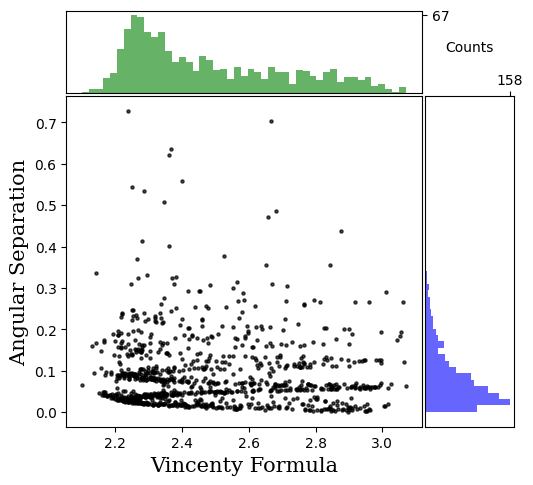

In [36]:
grasp.plots.doubleHistScatter(theta_2.computed_values, theta_1.computed_values, xlabel='Vincenty Formula', ylabel='Angular Separation')